# VAE Experiments

This notebook is for experimenting with VAE as it pertains to audio waveforms. We begin, as always with some imports

In [206]:
import torch
from torch import nn
import numpy as np
import matplotlib.pylab as plt
import scipy
import glob
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
import random

Create a helper function to convert wave files and plot them

/var/folders/qg/j6x9_h7n6w9d9vc2fq0qg8_m0000gn/T/ipykernel_4044/3079094626.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  wav = scipy.io.wavfile.read(wav)[1]


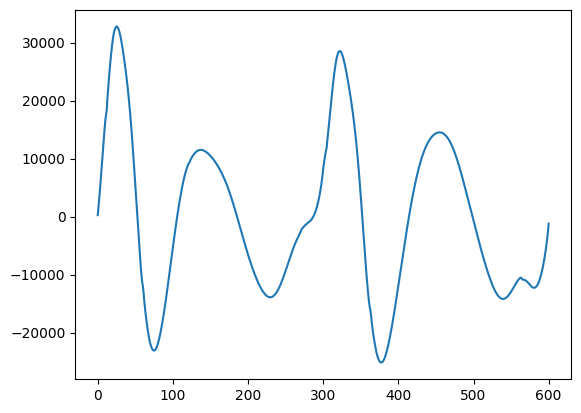

In [207]:
def wave_to_numpy(wav):
    wav = scipy.io.wavfile.read(wav)[1]
    # wav = wav/np.max(np.abs(wav))
    return wav.astype('float')

def plot_wav(wav: np.array):
    time = np.linspace(0., len(wav), wav.shape[0])
    plt.plot(time, wav)
    plt.show()
    
wav = wave_to_numpy("./AKWF/AKWF_0001/AKWF_0001.wav")
plot_wav(wav)

# Load the data

First we will make a function that simply reads a wave file and returns a numpy array of the data

(512,)


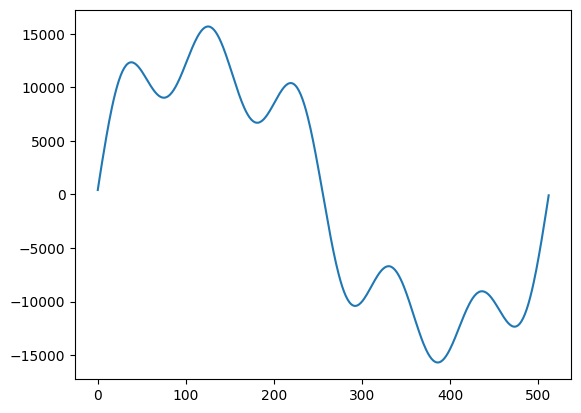

In [208]:
waveforms_data = []
for filename in glob.iglob("./AKWF-FREE/AKWF--Surge/AKWF-512/**/*.wav"):
    arr = wave_to_numpy(filename)
    if arr.ndim != 1:
        arr = arr[:,0]
    waveforms_data.append(arr)
    
WAVELENGTH = waveforms_data[0].shape[0]
print(waveforms_data[0].shape)
plot_wav(waveforms_data[0])

Permute the data

In [209]:
def split_and_combine(waveforms_data):
    # pick two random waveforms
    w1 = random.choice(waveforms_data)
    w2 = random.choice(waveforms_data)
    
    buf = 10
    # pick a random point to combine them
    point = random.randint(buf, WAVELENGTH - buf)
    front = w1[:buf]
    rear = w2[WAVELENGTH - buf:]
    
    # combine them
    combined = np.concatenate([w1[:point], w2[point:]])
    combined = combined[buf:WAVELENGTH-buf]
    combined = np.concatenate([front, combined, rear])
    
    return combined

permuted = []
for i in range(len(waveforms_data)):
    permuted.append(split_and_combine(waveforms_data))
    
    
def random_combine(waveforms_data):
    w1 = random.choice(waveforms_data)
    w2 = random.choice(waveforms_data)
    
    p = 2
    while (p > 0.9 or p < 0.1):
        p = np.random.normal(loc=0.5, scale=0.25)
    
    w1 *= p
    w2 *= (1-p)
    out = np.add(w1, w2)
    return out

for i in range(len(waveforms_data)):
    permuted.append(random_combine(waveforms_data))
    
def synthetic_squares(waveforms_data):
    x = np.random.randint(1, 5)
    p = np.random.uniform()
    square = scipy.signal.square(np.linspace(-x*np.pi, x*np.pi, WAVELENGTH), duty=p)
    point = random.randint(0, WAVELENGTH)
    square = np.concatenate([square[point:], square[:point]])
    w = random.choice(waveforms_data)
    
    p = 2
    while (p > 0.99 or p < 0.3):
        p = np.random.normal(loc=0.5, scale=0.25)
        
    out = np.add(square * p, w * (1-p))
    return out

for i in range(len(waveforms_data)):
    permuted.append(synthetic_squares(waveforms_data))


for i in range(int(len(waveforms_data) * 20)):
    permuted.append(synthetic_squares(waveforms_data))

waveforms_data.extend(permuted)
print(len(waveforms_data))
for i in range(100_000):
    waveforms_data.append(random_combine(waveforms_data))
    waveforms_data.append(synthetic_squares(waveforms_data))

waveforms_data.extend(flipped)
waveforms_data = [wf / np.max(np.abs(wf)) for wf in waveforms_data]
len(waveforms_data)

104592


448476

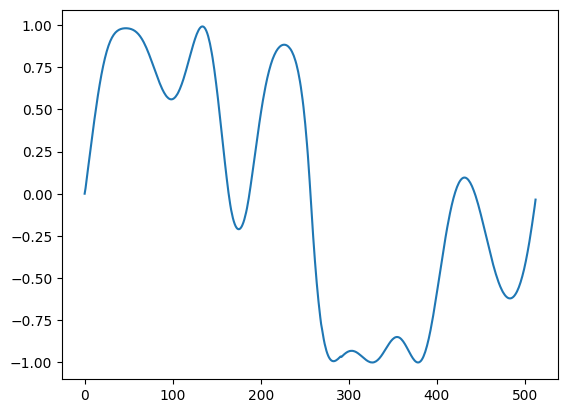

In [237]:
wf = random.choice(waveforms_data)
plot_wav(wf)

In [134]:
train, test = train_test_split(waveforms_data, test_size=0.2)
train_dataloader = DataLoader(train, batch_size=512, shuffle=True)
test_dataloader = DataLoader(test, batch_size=512, shuffle=True)

In [101]:
class Encoder(nn.Module):
    def __init__(self, in_dim=600, latent_dim=8, dropout_p=0.2):

        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(in_dim, 384),
            nn.Dropout(dropout_p),
            nn.ReLU(),
            nn.Linear(384, 256),
            nn.Dropout(dropout_p),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.Dropout(dropout_p),
            nn.ReLU(),
            nn.Linear(128, latent_dim),
        )
        
    def forward(self, x):
        return self.encoder(x)
        

class Decoder(nn.Module):
    def __init__(self, out_dim=600, latent_dim=8, dropout_p=0.2):
        super().__init__()
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.Dropout(dropout_p),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.Dropout(dropout_p),
            nn.ReLU(),
            nn.Linear(256, 384),
            nn.Dropout(dropout_p),
            nn.ReLU(),
            nn.Linear(384, out_dim),
        )
    def replace_dropout(self, dropout_p=0.2):
        self.decoder[1] = nn.Dropout(dropout_p)
        self.decoder[4] = nn.Dropout(dropout_p)
    
    def forward(self, x):
        return self.decoder(x)
    

class AutoEncoder(nn.Module):
    def __init__(self, orig_dim=600, latent_dim=8, dropout_p=0.2):
        super().__init__()
        self.encoder = Encoder(orig_dim, latent_dim, dropout_p=dropout_p)
        self.decoder = Decoder(orig_dim, latent_dim, dropout_p=0.5)
    
    def forward(self, x):
        latent = self.encoder(x)
        return self.decoder(latent)

In [102]:
for batch in train_dataloader:
    print(type(batch))
    print(batch.shape)
    break

<class 'torch.Tensor'>
torch.Size([512, 512])


In [124]:
n_epochs = 100
latent_dim = 64
model = AutoEncoder(WAVELENGTH, latent_dim)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

model.train()
with tqdm(total=n_epochs) as pbar:
    for i in range(n_epochs):
        loss_total = 0
        model.train()
        for batch in train_dataloader:
            y = batch.float()
            y_hat = model(y)
            optimizer.zero_grad()
            loss = nn.functional.mse_loss(y_hat, y)
            loss_total += loss
            loss.backward()
            optimizer.step()
        model.eval()
        valid_loss_total = 0
        for batch in test_dataloader:
            y = batch.float()
            y_hat = model(y)
            loss = nn.functional.mse_loss(y_hat, y)
            valid_loss_total += loss
        pbar.set_postfix({"Training loss": loss_total.item() / len(train_dataloader),
                          "Validation Loss": valid_loss_total.item() / len(test_dataloader)})
        pbar.update(1)

  0%|          | 0/100 [00:00<?, ?it/s]

In [125]:
test_in = next(iter(test_dataloader))[0].float()
model.eval()
latent = model.encoder(test_in)
print(latent)
print(np.random.normal(loc=0, scale=25, size=(latent_dim,)))


tensor([-0.0346,  0.0175, -0.0132, -0.0010, -0.0186, -0.2133, -0.0145, -0.0061,
         0.0973, -0.0060,  0.0048, -0.0290,  0.0172, -0.0437, -0.0189,  0.0193,
        -0.0203, -0.2607, -0.0080,  0.0106,  0.0070,  0.0135, -0.0044,  0.0766,
        -0.1547,  0.0407,  0.0453, -0.0079, -0.0167,  0.0287,  0.0964, -0.1504,
        -0.0066,  0.4376, -0.0474,  0.0558,  0.0114,  0.0042, -0.0020,  0.1017,
         0.0078,  0.0373,  0.0859, -0.0207, -0.0055, -0.0120, -0.0318,  0.0563,
        -0.1091,  0.0310,  0.0255, -0.0202,  0.0062, -0.0811,  0.0222, -0.0352,
        -0.0402,  0.0313, -0.0214,  0.1561,  0.0227, -0.1387, -0.0233,  0.0140],
       grad_fn=<AddBackward0>)
[  4.97056939  11.881262    18.7410868   30.22710221  22.44135536
 -21.28802038 -11.3855806   -4.62448106  21.24069762   1.19442566
 -24.30322246   4.88100391   3.90800864  18.54339094   6.9671727
  -7.65495829 -15.68603056  -9.41076535   2.52505863   1.59067648
  18.60542666  13.67379983   7.51825012  10.87371816  30.41657446

Dropout(p=0.9500000000000001, inplace=False)


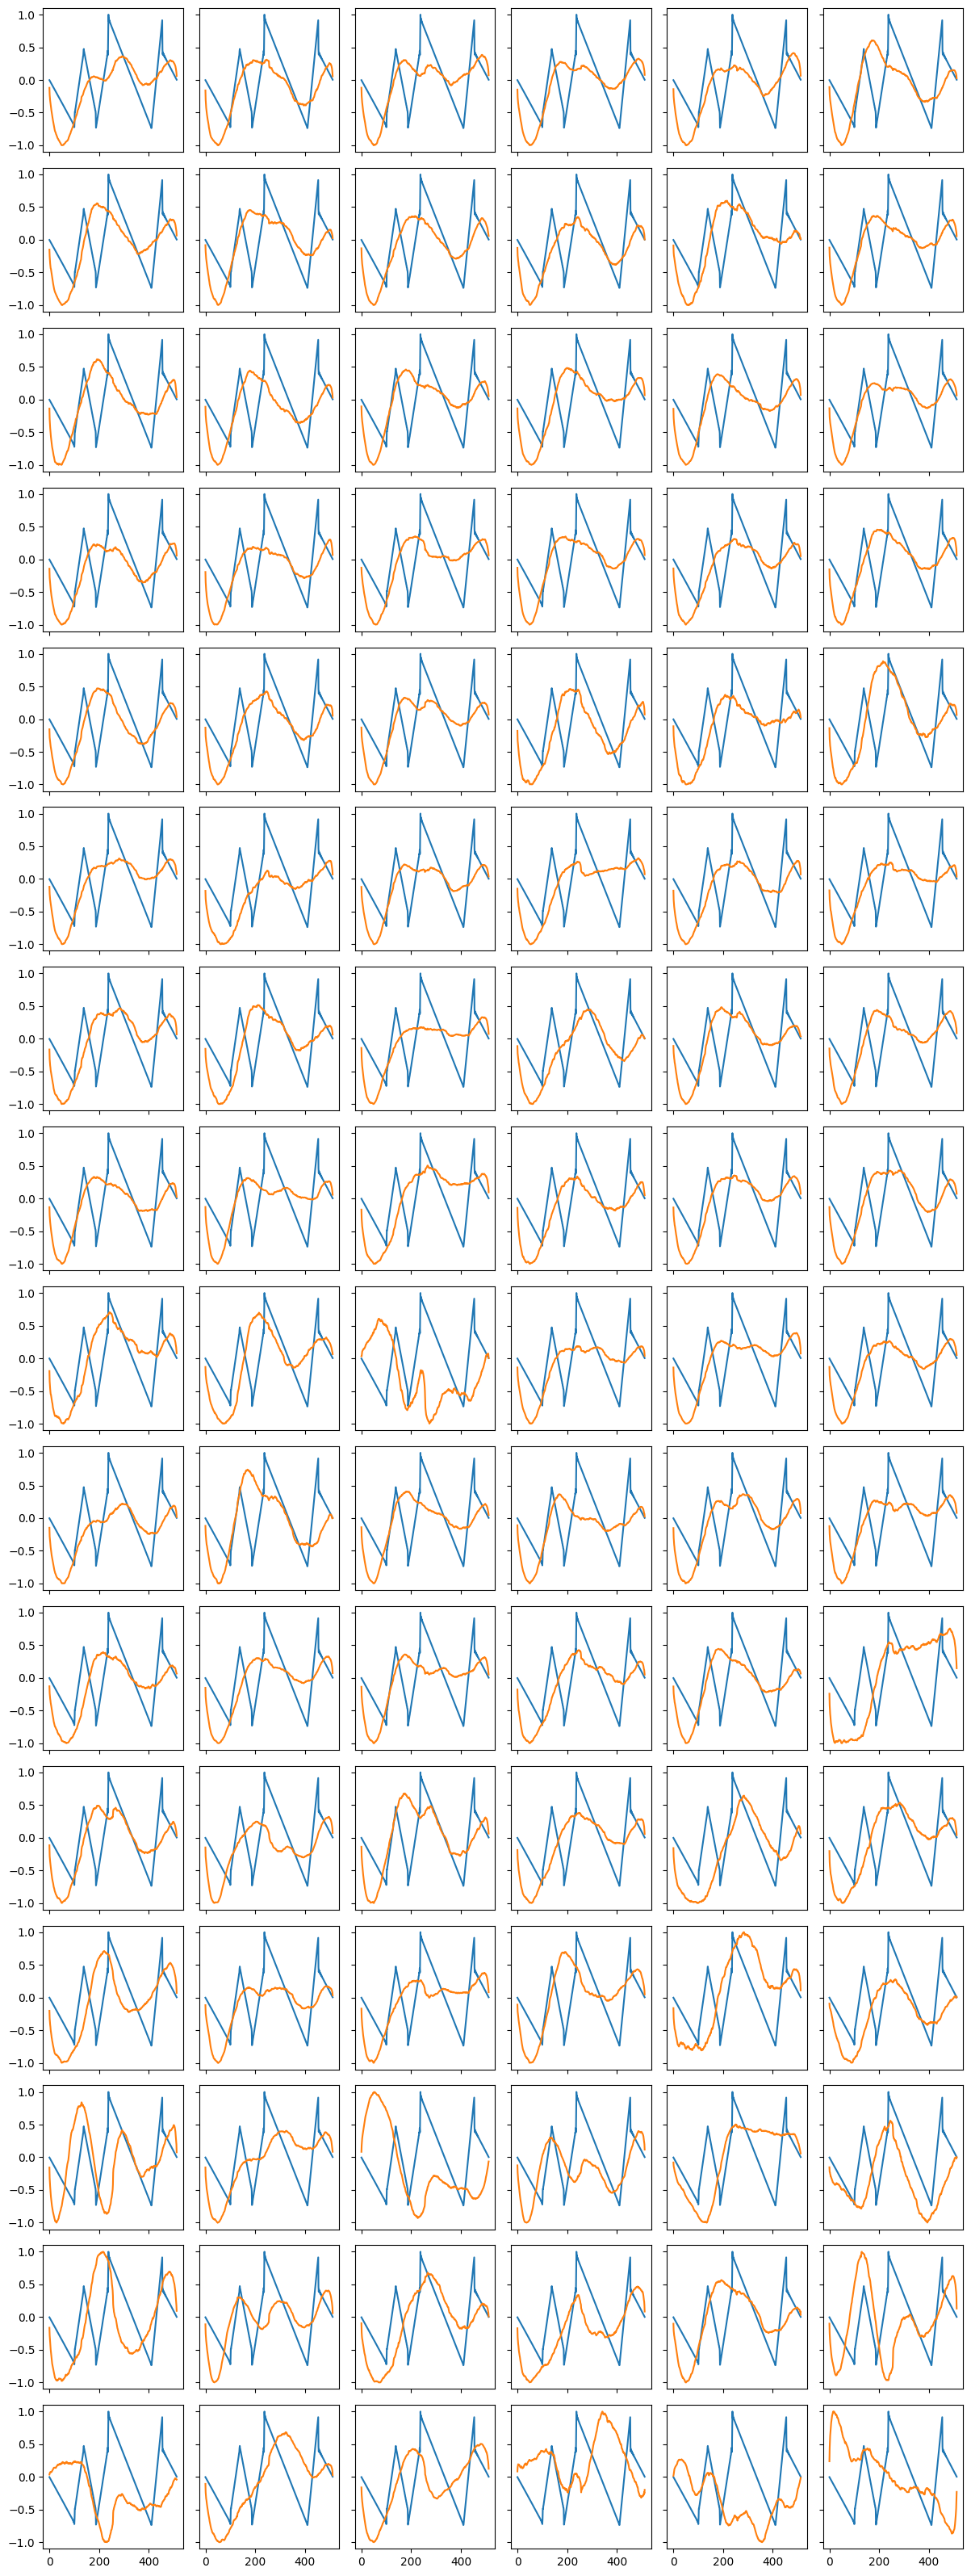

In [128]:
test_in = next(iter(test_dataloader))[0].float()
model.eval()
latent = model.encoder(test_in)
norm_test_in = test_in.detach().numpy() / np.max(test_in.detach().numpy())

model.train()
print(model.decoder.decoder[1])
def gen_n(n):
    out = []
    for i in range(n):
        # latent = np.random.normal(loc=0, scale=100, size=(latent_dim,))
        model.decoder.replace_dropout(i * 0.01)
        # latent[0] = -0.3048 * i
        # latent[1] = 1.23456 * i
        # latent = torch.tensor(latent).float()
        
        pred = model.decoder(latent).detach().numpy()
        # print(pred.shape, test_in.shape)
        # pred = np.add(pred, test_in.detach().numpy())
        pred /= np.max(np.abs(pred), axis=0)
        out.append(pred)
    return out

out = gen_n(96)
col = 6
row = 16
x = np.linspace(0, WAVELENGTH, WAVELENGTH)
fig, axs = plt.subplots(row, col, sharex=True, sharey=True, figsize=(12, 32))
for r in range(row):
    for c in range(col):
        idx = (r * col) + c
        axs[r][c].plot(x, norm_test_in)
        axs[r][c].plot(x, out[idx])
        
fig.tight_layout()

In [ ]:
model_parameters = filter(lambda p: p.requires_grad, model.decoder.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params * 4 / 1024 / 1024)

1.2626953125


In [112]:
print(latent_dim)

4
